In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/sbokupripeku/git/side_projects/learning_analytics'

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split



%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
df = pd.read_csv('data/preprocessed_data.csv')

In [135]:
df.tail()

,ISU_ID,GENDER,ADMITTED_EXAMS_SUM,RUSSIAN_LANG,MATH,PHYSICS,CHEMISTRY,FOREIGN_LANG,INFORMATICS,SOCIAL_STUDIES,REGION_ID,CURRENT_STATUS,DROPPED_BEFORE,START_YEAR,AGE_AT_START,HONS_TARGET,DROPPED_TARGET,MARKS_MEAN_SEM_1,MARKS_MEAN_SEM_2,PROGRAM_01,PROGRAM_09,PROGRAM_10,PROGRAM_11,PROGRAM_12,PROGRAM_13,PROGRAM_14,PROGRAM_15,PROGRAM_16,PROGRAM_18,PROGRAM_19,PROGRAM_23,PROGRAM_24,PROGRAM_27,PROGRAM_38,PROGRAM_44,PROGRAM_45,ADMISSION_COND_без вступительных испытаний,ADMISSION_COND_на бюджетное место в пределах особой квоты,ADMISSION_COND_на бюджетное место в пределах целевой квоты,ADMISSION_COND_на выделенное бюджетное место (для жителей Крыма),ADMISSION_COND_на контрактной основе,ADMISSION_COND_по общему конкурсу,RUSSIAN_LANG_BIN,MATH_BIN,PHYSICS_BIN,CHEMISTRY_BIN,FOREIGN_LANG_BIN,INFORMATICS_BIN,SOCIAL_STUDIES_BIN,Физика,nan,Иностранный язык,Химия,Русский язык,Биология,Информатика,Обществознание,Математика,ADMISSION_TYPE_100 баллов за олимпиаду,ADMISSION_TYPE_ЕГЭ,ADMISSION_TYPE_nan,ADMITTED_SUBJECT_PRIZE_LEVEL_0.0,ADMITTED_SUBJECT_PRIZE_LEVEL_1.0,ADMITTED_SUBJECT_PRIZE_LEVEL_2.0,ADMITTED_SUBJECT_PRIZE_LEVEL_3.0,ADMITTED_SUBJECT_PRIZE_LEVEL_4.0,ADMITTED_SUBJECT_PRIZE_LEVEL_nan,ADMITTED_EXAMS_SUM_BIN,NATIONALITY_Белоруссия,NATIONALITY_Вьетнам,NATIONALITY_КНР,NATIONALITY_Казахстан,NATIONALITY_Киргизия,NATIONALITY_Российская Федерация,NATIONALITY_Таджикистан,NATIONALITY_Туркмения,NATIONALITY_Узбекистан,NATIONALITY_Украина,NATIONALITY_другая страна,MACRO_BIRTH_PLACE_архангельск и ао,MACRO_BIRTH_PLACE_белоруссия,MACRO_BIRTH_PLACE_волгоград и во,MACRO_BIRTH_PLACE_воронеж и во,MACRO_BIRTH_PLACE_вьетнам,MACRO_BIRTH_PLACE_другая страна,MACRO_BIRTH_PLACE_другой город (РФ),MACRO_BIRTH_PLACE_екатеринбург и со,MACRO_BIRTH_PLACE_ижевск и ио,MACRO_BIRTH_PLACE_иркутс и ио,MACRO_BIRTH_PLACE_казань и рт,MACRO_BIRTH_PLACE_казахстан,MACRO_BIRTH_PLACE_киргизия,MACRO_BIRTH_PLACE_кнр,MACRO_BIRTH_PLACE_красноярск и кк,MACRO_BIRTH_PLACE_москва и мо,MACRO_BIRTH_PLACE_мурманск и мо,MACRO_BIRTH_PLACE_нижний новгород и но,MACRO_BIRTH_PLACE_новосибирск и но,MACRO_BIRTH_PLACE_оренбург и оо,MACRO_BIRTH_PLACE_пермь и пк,MACRO_BIRTH_PLACE_петрозаводск и рк,MACRO_BIRTH_PLACE_ростов-на-дону и ро,MACRO_BIRTH_PLACE_самара и со,MACRO_BIRTH_PLACE_санкт-петербург и ло,MACRO_BIRTH_PLACE_саратов и со,MACRO_BIRTH_PLACE_таджикистан,MACRO_BIRTH_PLACE_томск и то,MACRO_BIRTH_PLACE_туркмения,MACRO_BIRTH_PLACE_узбекистан,MACRO_BIRTH_PLACE_украина,MACRO_BIRTH_PLACE_уфа и рб,MACRO_BIRTH_PLACE_челябинск и чо,SCHOLARSHIP_TYPE_Бронзовый ЕГЭ,SCHOLARSHIP_TYPE_Золотой ЕГЭ,SCHOLARSHIP_TYPE_Золотой Олимпиада,SCHOLARSHIP_TYPE_Серебряный ЕГЭ,SCHOLARSHIP_TYPE_Серебряный Олимпиада,SCHOLARSHIP_TYPE_nan,DORMITORY_FOR_STUDY_0.0,DORMITORY_FOR_STUDY_1.0,DORMITORY_FOR_STUDY_nan
20569,265000,1,286.0,98.0,88.0,86.0,86.0,88.0,100.0,78.0,78.0,обучен,0.0,2018-09-01,18.0,0.0,NaN,4.20,4.500000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
20570,243784,1,247.0,86.0,78.0,80.0,79.0,88.5,84.0,66.0,NaN,диплом,0.0,2017-09-01,17.0,0.0,1.0,3.75,4.428571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
20571,265389,0,257.0,91.0,82.0,86.0,86.0,88.0,84.0,78.0,75.0,обучен,0.0,2018-09-01,18.0,0.0,NaN,4.75,5.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
20572,242366,1,252.0,86.0,72.0,86.0,86.0,88.0,100.0,78.0,2.0,обучен,0.0,2018-09-01,18.0,0.0,NaN,4.00,3.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

### Drop rows with NaN

In [136]:
df = df[df.MARKS_MEAN_SEM_1.notna()]

In [137]:
df.shape

(18233, 121)

### Drop unused columns

In [138]:
DROP_COLS = ["HONS_TARGET", "DROPPED_TARGET", "ISU_ID", "MARKS_MEAN_SEM_2", 
                 "CURRENT_STATUS", "REGION_ID"]

In [170]:
filtered_df = df.drop(columns=DROP_COLS)

In [171]:
filtered_df.columns[filtered_df.isna().any()]

Index(['AGE_AT_START'], dtype='object')

In [172]:
filtered_df = filtered_df[filtered_df.AGE_AT_START.notna()]

In [173]:
filtered_df.shape

(18231, 115)

In [174]:
target = filtered_df.MARKS_MEAN_SEM_1
final_df = filtered_df.drop(columns=['MARKS_MEAN_SEM_1'])

In [175]:
final_df['YEAR'] = final_df.START_YEAR.map(lambda x: int(x.split('-')[0]))

In [176]:
final_df.drop(columns=['START_YEAR'], inplace=True)

### Train Linear regression

Train on data before a year, predict data in this year

In [227]:
year_predicted = 2017

In [228]:
target_train = target[final_df.YEAR < year_predicted]
target_test = target[final_df.YEAR == year_predicted]
print(target_train.shape, target_test.shape)

(9343,) (1373,)


In [423]:
df_train = final_df[final_df.YEAR < year_predicted]
df_test = final_df[final_df.YEAR == year_predicted]

df_train.drop(columns=['YEAR'], inplace=True)
df_test.drop(columns=['YEAR'], inplace=True)

print(df_train.shape, df_test.shape)

(9343, 113) (1373, 113)


In [424]:
X_train = df_train.to_numpy()
y_train = target_train.to_numpy()

In [425]:
X_test = df_test.to_numpy()
y_test = target_test.to_numpy()

In [426]:
np.any(np.isnan(X_train)), np.any(np.isnan(y_train)), np.any(np.isnan(X_test)), np.any(np.isnan(y_test))

(False, False, False, False)

In [427]:
X_train.shape, y_train.shape

((9343, 113), (9343,))

In [428]:
X_test.shape, y_test.shape

((1373, 113), (1373,))

In [429]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_norm_train = scaler.fit_transform(X_train)
X_norm_test = scaler.fit_transform(X_test)
clf = Lasso(alpha=0.001)

clf.fit(X_norm_train, y_train)

Lasso(alpha=0.001)

In [430]:
np.mean(y_test)

4.217619788916791

In [431]:
np.mean(clf.predict(X_norm_test))

3.924634812848638

In [432]:
np.sqrt(mean_squared_error(y_pred=clf.predict(X_norm_test), y_true=y_test))

0.595165089497471

### Feature importance

In [433]:
coefs = clf.coef_
sorted_coef_indices = np.flip(np.argsort(np.abs(coefs)))

columns = df_train.columns.to_numpy()


In [438]:
first_k = 15
large_coefs = [coefs[ind] for ind in sorted_coef_indices[:first_k]]
large_column_names = [columns[ind] for ind in sorted_coef_indices[:first_k]]

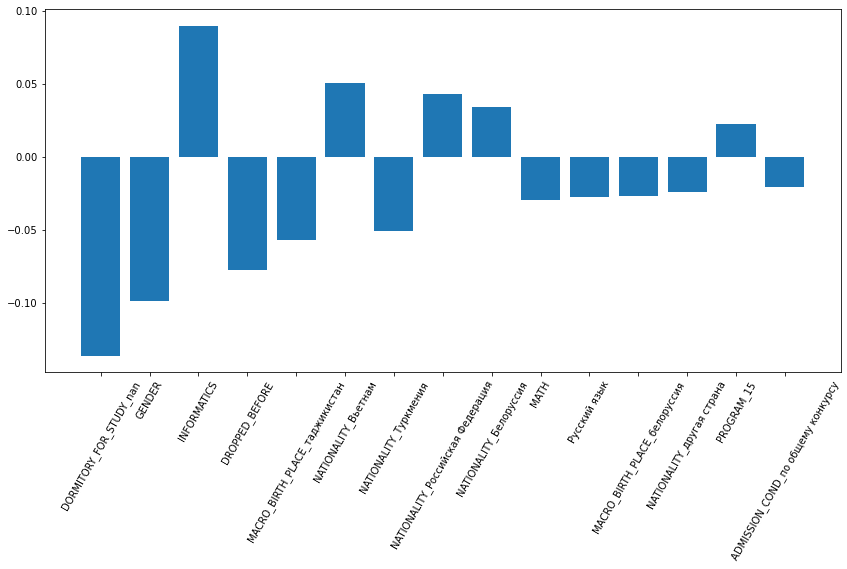

In [439]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

x = list(range(len(large_coefs)))
plt.bar(x, large_coefs)
plt.xticks(x, large_column_names, rotation=60)
plt.tight_layout()

In [443]:
[columns[ind] for ind in sorted_coef_indices[:35]]

['DORMITORY_FOR_STUDY_nan',
 'GENDER',
 'INFORMATICS',
 'DROPPED_BEFORE',
 'MACRO_BIRTH_PLACE_таджикистан',
 'NATIONALITY_Вьетнам',
 'NATIONALITY_Туркмения',
 'NATIONALITY_Российская Федерация',
 'NATIONALITY_Белоруссия',
 'MATH',
 'Русский язык',
 'MACRO_BIRTH_PLACE_белоруссия',
 'NATIONALITY_другая страна',
 'PROGRAM_15',
 'ADMISSION_COND_по общему конкурсу',
 'NATIONALITY_КНР',
 'PROGRAM_10',
 'ADMISSION_TYPE_100 баллов за олимпиаду',
 'CHEMISTRY_BIN',
 'SOCIAL_STUDIES',
 'ADMITTED_SUBJECT_PRIZE_LEVEL_3.0',
 'PROGRAM_45',
 'MACRO_BIRTH_PLACE_нижний новгород и но',
 'NATIONALITY_Киргизия',
 'AGE_AT_START',
 'PROGRAM_11',
 'ADMITTED_SUBJECT_PRIZE_LEVEL_1.0',
 'MACRO_BIRTH_PLACE_екатеринбург и со',
 'NATIONALITY_Казахстан',
 'PROGRAM_01',
 'RUSSIAN_LANG_BIN',
 'PHYSICS',
 'PROGRAM_27',
 'FOREIGN_LANG',
 'MACRO_BIRTH_PLACE_вьетнам']

In [ ]:

# Create table with rmse, write about 4 grade scale (from 2 to 5, with 3 being passing grade)

In [130]:
# Calculate feature importances

In [377]:
# Check model assumptions